<a href="https://colab.research.google.com/github/Louis5228/Digital-Image-Process/blob/main/Image_segmentation_based_on_thresholding_and_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import math
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Digital Image Process/HW6")

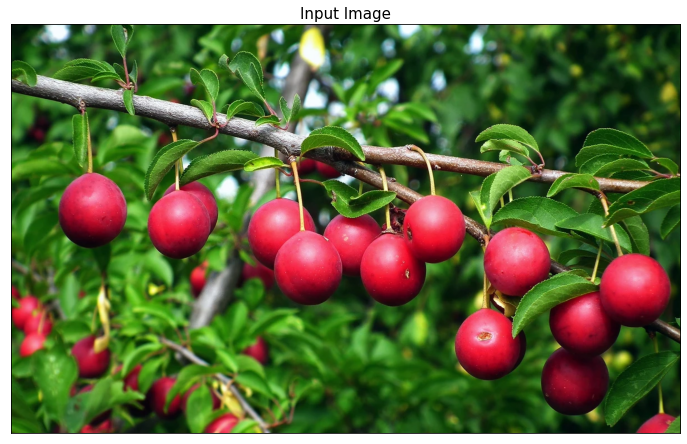

In [101]:
# load image
img = cv2.imread('fruit on tree.tif')
show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.title('Input Image', fontsize = 15), plt.xticks([]), plt.yticks([])
plt.imshow(show_img)
plt.show()

# Otsu’s optimal global thresholding (single threshold) to R component

In [102]:
def cal_global_mean(prob_dist):
  return np.sum(np.arange(256) * prob_dist)

def cal_between_class_var(prob_dist, threshold, glob_m):
  prob_1 = np.sum(prob_dist[:threshold+1])
  prob_2 = 1.0 - prob_1
  mean_1 = np.sum(np.arange(0, threshold+1) * prob_dist[:threshold+1]) / prob_1
  mean_2 = np.sum(np.arange(threshold+1, 256) * prob_dist[threshold+1:]) / prob_2
  var = prob_1*(mean_1 - glob_m)**2 + prob_2*(mean_2 - glob_m)**2
  return var

In [103]:
r = img[:,:,2]

# Apply Otsu’s optimal global thresholding
normal_hist, bin_edges  = np.histogram(r, bins=np.arange(257), density=True)
glob_m = cal_global_mean(normal_hist)
var_l = list()
for k in range(255):
  var = cal_between_class_var(normal_hist, k, glob_m)
  var_l.append(var)

# Calculate Maximum Between Class Variance
max_var = max(var_l)
optimal_threshold = var_l.index(max_var)

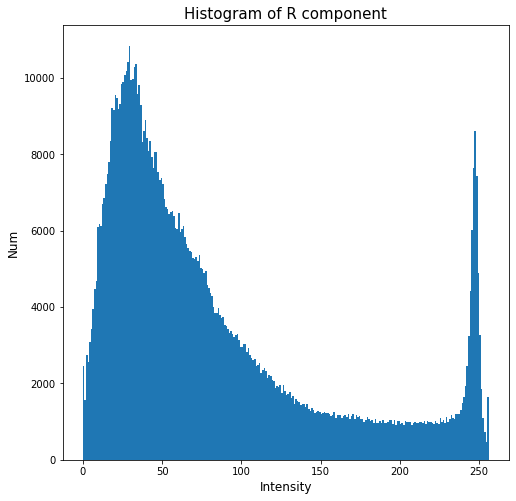

In [108]:
plt.figure(figsize=(8,8))
plt.title('Histogram of R component', fontsize = 15)
plt.xlabel("Intensity", fontsize = 12)
plt.ylabel("Num", fontsize = 12)
plt.hist(r.ravel(),256,[0,256])
plt.show()

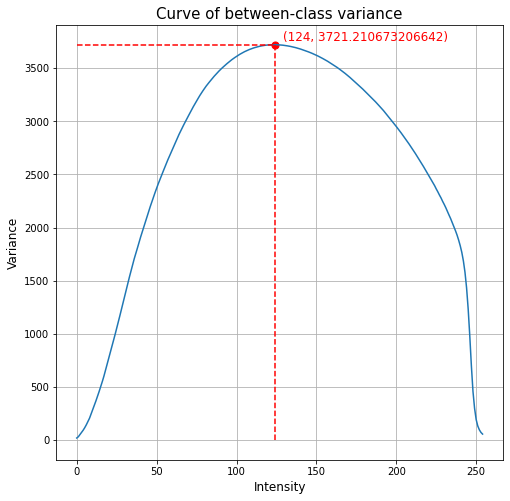

In [107]:
plt.figure(figsize=(8,8))
plt.title('Curve of between-class variance', fontsize = 15)
plt.xlabel("Intensity", fontsize = 12)
plt.ylabel("Variance", fontsize = 12)
x = np.arange(255)
y = var_l
plt.plot(x, y)
plt.scatter(optimal_threshold, max_var, s=50, c='r')
plt.plot([0,optimal_threshold], [max_var, max_var], c='r', linestyle='--')
plt.plot([optimal_threshold, optimal_threshold], [0, max_var], c='r', linestyle='--')
plt.text(optimal_threshold+5, max_var+10, '('+str(optimal_threshold)+', '+str(max_var)+')', c='r', va='bottom', fontsize=12)
plt.grid(True)
plt.show()

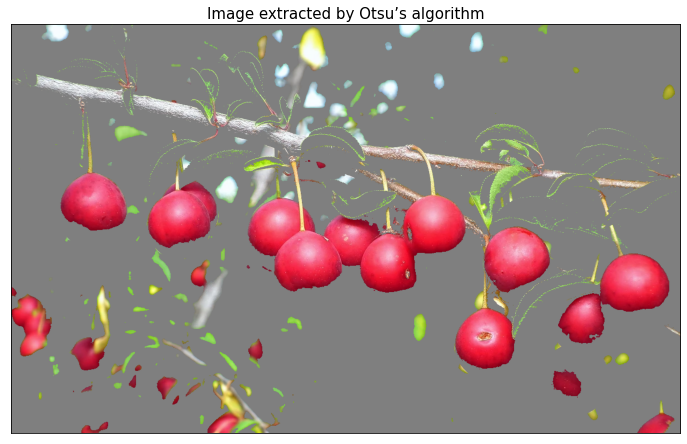

In [109]:
segment_img_Otsu = np.copy(img)
mask = r > optimal_threshold
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if mask[i,j] == 0:
      segment_img_Otsu[i,j] = 127

plt.figure(figsize=(12,12))
plt.title('Image extracted by Otsu’s algorithm', fontsize = 15), plt.xticks([]), plt.yticks([])
show_segment_img_Otsu = cv2.cvtColor(segment_img_Otsu, cv2.COLOR_BGR2RGB)
plt.imshow(show_segment_img_Otsu)
plt.show()

# K-means clustering using T = 1, 5 and 10 to the full-color image (RGB)

In [110]:
N = 0
T = [10, 5, 1]
k_means_img = np.copy(img)

# 群集中心和元素的數量
seed_num = 2
dot_num = img.shape[0]*img.shape[1]

# 初始元素
x = img[:,:,0].reshape((-1))  # b
y = img[:,:,1].reshape((-1))  # g
z = img[:,:,2].reshape((-1))  # r
# 初始群集中心
kx = np.random.randint(0, 256, seed_num)
ky = np.random.randint(0, 256, seed_num)
kz = np.random.randint(0, 256, seed_num)

# 兩點之間的距離
def dis(x, y, z, kx, ky, kz):
    return int(((kx-x)**2 + (ky-y)**2 + (kz-z)**2)**0.5)

# 對每筆元素進行分群
def cluster(x, y, z, kx, ky, kz):
  team = []
  indx = []
  for i in range(seed_num):
      team.append([])
      indx.append([])
  mid_dis = 99999999
  for i in range(dot_num):
    for j in range(seed_num):
      distant = dis(x[i], y[i], z[i], kx[j], ky[j], kz[j])
      if distant < mid_dis:
        mid_dis = distant
        flag = j
    team[flag].append([x[i], y[i], z[i]])
    indx[flag].append(i)
    mid_dis = 99999999
  return team, indx

# 對分群完的元素找出新的群集中心
def re_seed(team, kx, ky, kz):
  sumx = 0
  sumy = 0
  sumz = 0
  new_seed = []
  for index, nodes in enumerate(team):
    if nodes == []:
      new_seed.append([kx[index], ky[index], kz[index]])
    for node in nodes:
      sumx += node[0]
      sumy += node[1]
      sumz += node[2]
    new_seed.append([int(sumx/len(nodes)), int(sumy/len(nodes)), int(sumz/len(nodes))])
    sumx = 0
    sumy = 0
    sumz = 0
  nkx = []
  nky = []
  nkz = []
  for i in new_seed:
    nkx.append(i[0])
    nky.append(i[1])
    nkz.append(i[2])
  return nkx, nky, nkz

# k-means 分群
def kmeans(x, y, z, kx, ky, kz, T, fig, N=N):
  team, indx = cluster(x, y, z, kx, ky, kz)
  nkx, nky, nkz = re_seed(team, kx, ky, kz)
  E = np.sum(((np.array(nkx)-kx)**2 + (np.array(nky)-ky)**2 + (np.array(nkz)-kz)**2)**0.5)
  print("m1 = (", nkx[0], ",", nky[0], ",", nkz[0], ")")
  print("m2 = (", nkx[1], ",", nky[1], ",", nkz[1], ")")
  print("E =", E)

  # 判斷新舊群集中心距離差的和是否小於Threshold
  if E <= T[N]:
    print("-"*15, "kmeans done", "-"*15)
    final_team, final_indx = cluster(x, y, z, nkx, nky, nkz)

    # 判斷前景或背景
    arr = np.sum(np.array((nkx, nky, nkz)), axis=0)
    back_g_indx = np.argmin(arr)
    for i in final_indx[back_g_indx]:
      k_means_img.reshape((-1, 3))[i] = 127
    # 繪圖
    plt.figure(figsize=(12,12))
    plt.title('Image extracted by K-means algorithm T = '+str(T[N]), fontsize = 15), plt.xticks([]), plt.yticks([])
    show_k_means_img = cv2.cvtColor(k_means_img, cv2.COLOR_BGR2RGB)
    plt.imshow(show_k_means_img)
    plt.show()

    N += 1
    if N == len(T):
      return
    else:
      fig += 1
      kmeans(x, y, z, nkx, nky, nkz, T, fig, N=N)
  else:
    fig += 1
    kmeans(x, y, z, nkx, nky, nkz, T, fig, N=N)

m1 = ( 39 , 86 , 77 )
m2 = ( 172 , 224 , 204 )
E = 246.89940798526206
m1 = ( 31 , 82 , 66 )
m2 = ( 149 , 166 , 205 )
E = 76.5793699260486
m1 = ( 27 , 82 , 57 )
m2 = ( 127 , 142 , 201 )
E = 42.65129673550956
m1 = ( 26 , 81 , 52 )
m2 = ( 117 , 133 , 195 )
E = 19.92707228536287
m1 = ( 25 , 81 , 50 )
m2 = ( 113 , 130 , 191 )
E = 8.639192214932638
--------------- kmeans done ---------------


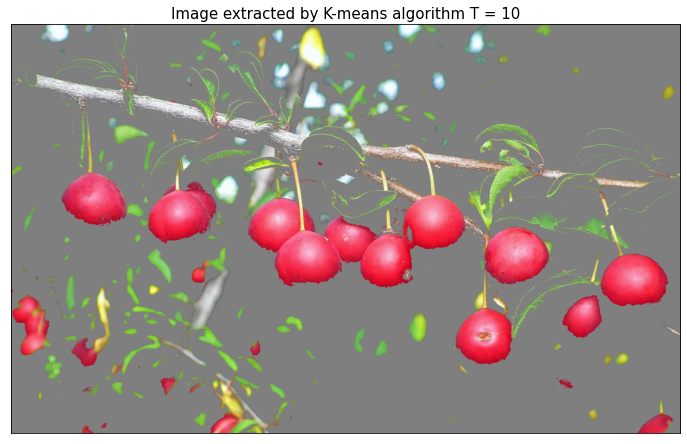

m1 = ( 24 , 81 , 49 )
m2 = ( 111 , 129 , 188 )
E = 5.155870949147037
m1 = ( 24 , 80 , 49 )
m2 = ( 110 , 129 , 187 )
E = 2.414213562373095
--------------- kmeans done ---------------


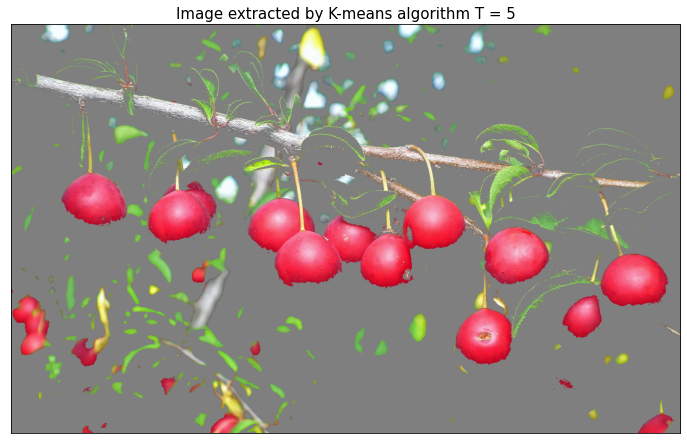

m1 = ( 24 , 80 , 49 )
m2 = ( 109 , 129 , 186 )
E = 1.4142135623730951
m1 = ( 24 , 80 , 49 )
m2 = ( 109 , 129 , 185 )
E = 1.0
--------------- kmeans done ---------------


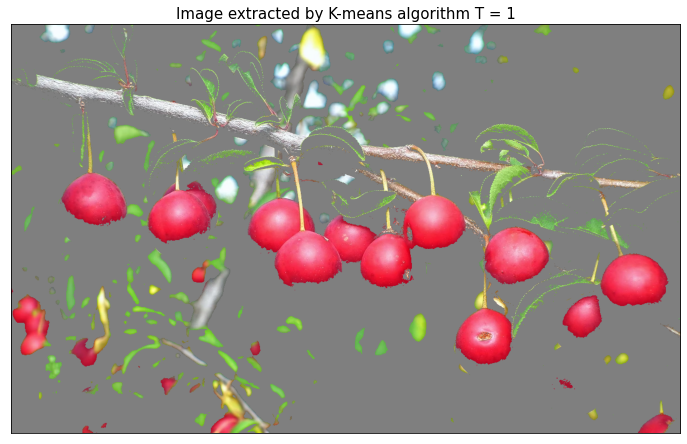

In [100]:
kmeans(x, y, z, kx, ky, kz, T, fig=0, N=N)